# Machine Learning for String Field Theory

*H. Erbin, R. Finotello, M. Kudrna, M. Schnabl*

## Abstract

In the framework of bosonic **Open String Field Theory** (OSFT), we consider several observables characterised by conformal weight, periodicity of the oscillations and the position of vacua in the potential for various values of truncated mass level.
We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we train the machine learning algorithms on the lumps dataset.
We keep only observables with vanishing conformal weight.

## General Observations

The idea is to improve the finite level predictions and reaching a result as close as possible to the extrapolated label.
In general we can first rescale all the labels to be in the interval $[-1, 1]$ (the lumps should already be in that interval).
We need to find a strategy to evaluate the extrapolated labels with respect to the finite level truncation.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import joblib
import time
from IPython.display import Image
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from tensorflow import keras
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from analysis import *

import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

# set matplot
sns.set()
SUFFIX = '_w0'

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# set random seed
RAND = 42
np.random.seed(RAND)
tf.random.set_seed(RAND)

In [2]:
# create shortcuts for paths
proot = lambda s: os.path.join('.', s)
pdata = lambda s: os.path.join(proot('data'), s)
pimg  = lambda s: os.path.join(proot('img'), s)
pmet  = lambda s: os.path.join(proot('metrics'), s)
pmod  = lambda s: os.path.join(proot('models'), s)

## Load the Dataset

In [3]:
df = pd.read_csv(pdata('lumps.csv'))
df = df.loc[df['weight'] == 0.0]
last = 'level_18'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 704
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   solution  135 non-null    int64  
 1   weight    135 non-null    float64
 2   type_2    135 non-null    int64  
 3   type_4    135 non-null    int64  
 4   level_2   135 non-null    float64
 5   level_3   135 non-null    float64
 6   level_4   135 non-null    float64
 7   level_5   135 non-null    float64
 8   level_6   135 non-null    float64
 9   level_7   135 non-null    float64
 10  level_8   135 non-null    float64
 11  level_9   135 non-null    float64
 12  level_10  135 non-null    float64
 13  level_11  135 non-null    float64
 14  level_12  135 non-null    float64
 15  level_13  135 non-null    float64
 16  level_14  135 non-null    float64
 17  level_15  135 non-null    float64
 18  level_16  135 non-null    float64
 19  level_17  135 non-null    float64
 20  level_18  135 non-null    float6

We need to:

1. define the evaluation metrics,
2. rescale the labels,
3. define the cross-validation strategy,
4. divide into training and test sets,
5. train the algorithms,
6. evaluate each algorithm.

## Evaluation Metric

In general we use the average ratio between the residuals of predicted level and the last finite truncation level:
\begin{equation}
    R(y_{true}, y_{finite}, y_{pred}) = \frac{1}{N} \sum\limits_{i = 1}^N \log_{10}\left| \frac{y_{true}^{(i)} - y_{pred}^{(i)}}{y_{true}^{(i)} - y_{finite}^{(i)}} \right|
\end{equation}
This way a negative result would represent an improvement on finite truncation levels.

## Cross-Validation Strategy

In [4]:
cv = KFold(n_splits=9)

## Train and Test Sets

In [5]:
train, test = train_test_split(df, train_size=0.9, shuffle=True, random_state=RAND)

X_train = train.filter(regex='solution|weight|type.*|level_.*')
X_train.to_csv(pdata('lumps_X_train' + SUFFIX + '.csv'), index=False)
X_train = X_train.drop(columns=['solution']).values

X_test  = test.filter(regex='solution|weight|type.*|level_.*')
X_test.to_csv(pdata('lumps_X_test' + SUFFIX + '.csv'), index=False)
X_test = X_test.drop(columns=['solution']).values

y_train = train['exp']
y_train.to_csv(pdata('lumps_y_train' + SUFFIX + '.csv'), index=False)
y_train = y_train.values.reshape(-1,)

y_test  = test['exp']
y_test.to_csv(pdata('lumps_y_test' + SUFFIX + '.csv'), index=False)
y_test = y_test.values.reshape(-1,)

In [6]:
print(f'Shape of the training set: X = {X_train.shape}, y = {y_train.shape}')
print(f'Shape of the test     set: X = {X_test.shape},  y = {y_test.shape}')

Shape of the training set: X = (121, 20), y = (121,)
Shape of the test     set: X = (14, 20),  y = (14,)


We also need a validation set (10% of the samples) for the neural networks:

In [7]:
train, validation = train_test_split(train, test_size=1/9, shuffle=False)

X_train_nn = train.filter(regex='solution|weight|type.*|level_.*')
X_train_nn.to_csv(pdata('lumps_X_train_nn' + SUFFIX + '.csv'), index=False)
X_train_nn = X_train_nn.drop(columns=['solution']).values

X_val_nn  = validation.filter(regex='solution|weight|type.*|level_.*')
X_val_nn.to_csv(pdata('lumps_X_val_nn' + SUFFIX + '.csv'), index=False)
X_val_nn = X_val_nn.drop(columns=['solution']).values

y_train_nn = train['exp']
y_train_nn.to_csv(pdata('lumps_y_train_nn' + SUFFIX + '.csv'), index=False)
y_train_nn = y_train_nn.values.reshape(-1,)

y_val_nn  = validation['exp']
y_val_nn.to_csv(pdata('lumps_y_val_nn' + SUFFIX + '.csv'), index=False)
y_val_nn = y_val_nn.values.reshape(-1,)

y_test_nn = y_test

In [8]:
print(f'Shape of the training   set (ANN): X = {X_train_nn.shape}, y = {y_train_nn.shape}')
print(f'Shape of the validation set (ANN): X = {X_val_nn.shape},  y = {y_val_nn.shape}')

Shape of the training   set (ANN): X = (107, 20), y = (107,)
Shape of the validation set (ANN): X = (14, 20),  y = (14,)


## Extract the Last Truncation Level

In [9]:
last_train    = X_train[:,-1].reshape(-1,)
last_train_nn = X_train_nn[:,-1].reshape(-1,)
last_val_nn   = X_val_nn[:,-1].reshape(-1,)
last_test     = X_test[:,-1].reshape(-1,)
last_test_nn  = X_test[:,-1].reshape(-1,)

## Apply Fourier Transform to Levels

In [10]:
# compute Fourier transform (for real input)
levels_train    = np.fft.rfft(X_train[:,3:], axis=1)
levels_train_nn = np.fft.rfft(X_train_nn[:,3:], axis=1)
levels_val_nn   = np.fft.rfft(X_val_nn[:,3:], axis=1)
levels_test     = np.fft.rfft(X_test[:,3:], axis=1)

# separate modulus and argument
levels_train_mod    = np.abs(levels_train)
levels_train_ang    = np.angle(levels_train) / np.pi
levels_train_nn_mod = np.abs(levels_train_nn)
levels_train_nn_ang = np.angle(levels_train_nn) / np.pi
levels_val_nn_mod   = np.abs(levels_val_nn)
levels_val_nn_ang   = np.angle(levels_val_nn) / np.pi
levels_test_mod     = np.abs(levels_test)
levels_test_ang     = np.angle(levels_test) / np.pi

# concatenate the arrays (the first imaginary part is identically vanishing)
levels_train_conc    = np.c_[levels_train_mod[:,1:], levels_train_ang[:,1:]]
levels_train_nn_conc = np.c_[levels_train_nn_mod[:,1:], levels_train_nn_ang[:,1:]]
levels_val_nn_conc   = np.c_[levels_val_nn_mod[:,1:], levels_val_nn_ang[:,1:]]
levels_test_conc     = np.c_[levels_test_mod[:,1:], levels_test_ang[:,1:]]

In [11]:
# reform the input vectors
X_train    = np.c_[X_train[:,0:3], levels_train_conc]
X_train_nn = np.c_[X_train_nn[:,0:3], levels_train_nn_conc]
X_val_nn   = np.c_[X_val_nn[:,0:3], levels_val_nn_conc]
X_test     = np.c_[X_test[:,0:3], levels_test_conc]

## Rescale the Truncation Levels

In [12]:
lev_scaler    = StandardScaler()
lev_scaler_nn = StandardScaler()

# scale the cross-validation levels
levels_train = lev_scaler.fit_transform(X_train[:,3:])
levels_test  = lev_scaler.transform(X_test[:,3:])

# scale the neural network labels
levels_train_nn = lev_scaler_nn.fit_transform(X_train_nn[:,3:])
levels_val_nn   = lev_scaler_nn.transform(X_val_nn[:,3:])
levels_test_nn  = lev_scaler_nn.transform(X_test[:,3:])

# insert the levels back
X_train[:,3:] = levels_train
X_test[:,3:]  = levels_test

X_train_nn[:,3:] = levels_train_nn
X_val_nn[:,3:]   = levels_val_nn
X_test_nn        = X_test
X_test_nn[:,3:]  = levels_test_nn

In [13]:
os.makedirs('./models', exist_ok=True)

In [14]:
# save the scalers
joblib.dump(lev_scaler, pmod('lumps_levels_cv_scaler' + SUFFIX + '.pkl'))
joblib.dump(lev_scaler_nn, pmod('lumps_levels_nn_scaler' + SUFFIX + '.pkl'))

['./models/lumps_levels_nn_scaler.pkl']

## Training

In [15]:
os.makedirs('./img', exist_ok=True)
os.makedirs('./metrics', exist_ok=True)

### Linear Regression (w/ $\ell_2$ regularisation)

In [16]:
spaces    = {'alpha':         Real(1.0e-8, 1.0e-1, prior='log-uniform'),
             'fit_intercept': Integer(0, 1),
             'normalize':     Integer(0, 1)
            }
estimator = BayesSearchCV(Ridge(tol=1.0e-5, random_state=RAND),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 107.368 seconds.


In [17]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.040 ± 0.002


In [18]:
# save best estimator
joblib.dump(best_estimator, pmod('lumps_lr' + SUFFIX + '.pkl'))

['./models/lumps_lr.pkl']

In [19]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet('lumps_lr_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,ridge
alpha,3.190915e-07
fit_intercept,1.000000e+00
normalize,0.000000e+00


In [20]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, suffix=SUFFIX, name='train_lr')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, suffix=SUFFIX, name='test_lr')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet('lumps_lr_metrics' + SUFFIX + '.csv'))
metrics

,train_lr,test_lr
mean_squared_error,0.022681,0.009452
mean_absolute_error,0.107094,0.080642
r2_score,0.898759,0.953685
residual_ratio,1.308308,1.091630


In [21]:
make_plots(estimator, X_train, y_train, last_train, suffix=SUFFIX, name='train_lr')
make_plots(estimator, X_test, y_test, last_test, suffix=SUFFIX, name='test_lr')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], suffix=SUFFIX, name='lr')

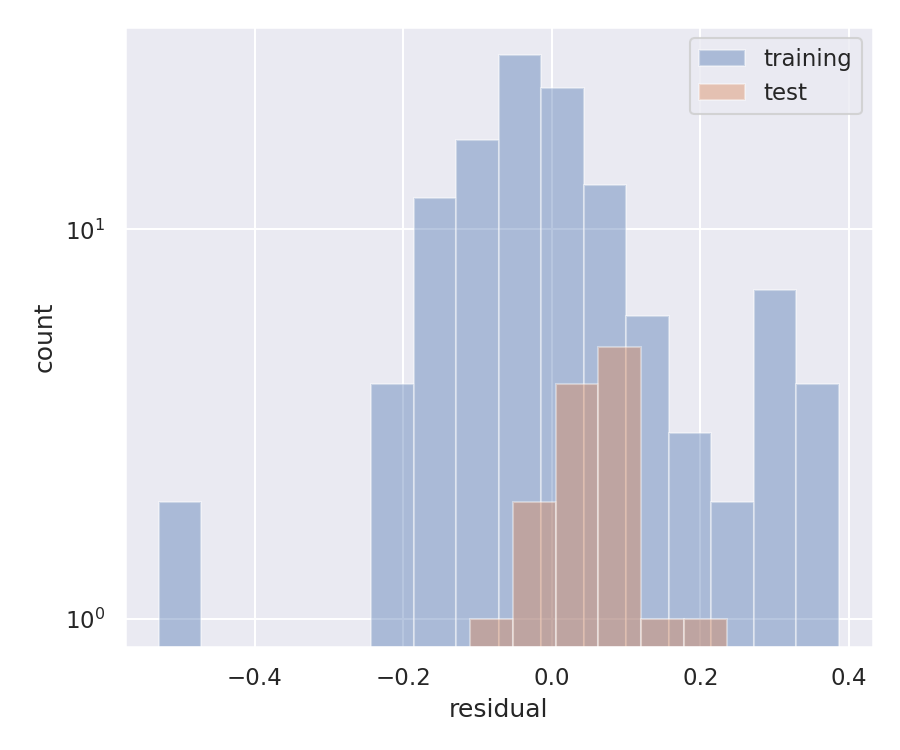

In [22]:
Image(pimg('lumps_lr_residual_histogram_compare' + SUFFIX + '.png'), width=480)

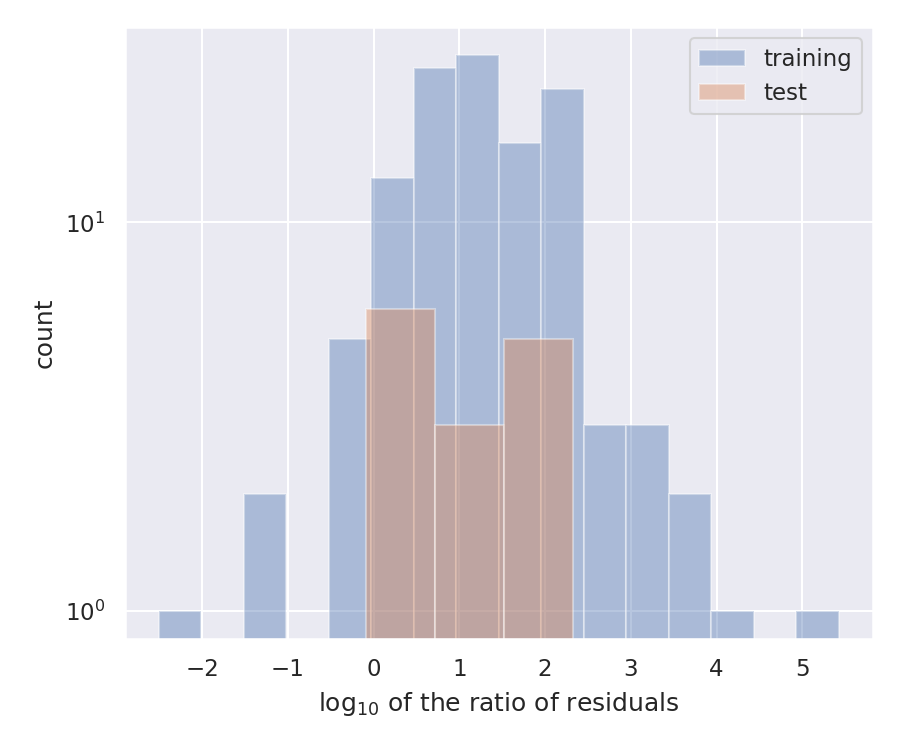

In [23]:
Image(pimg('lumps_lr_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

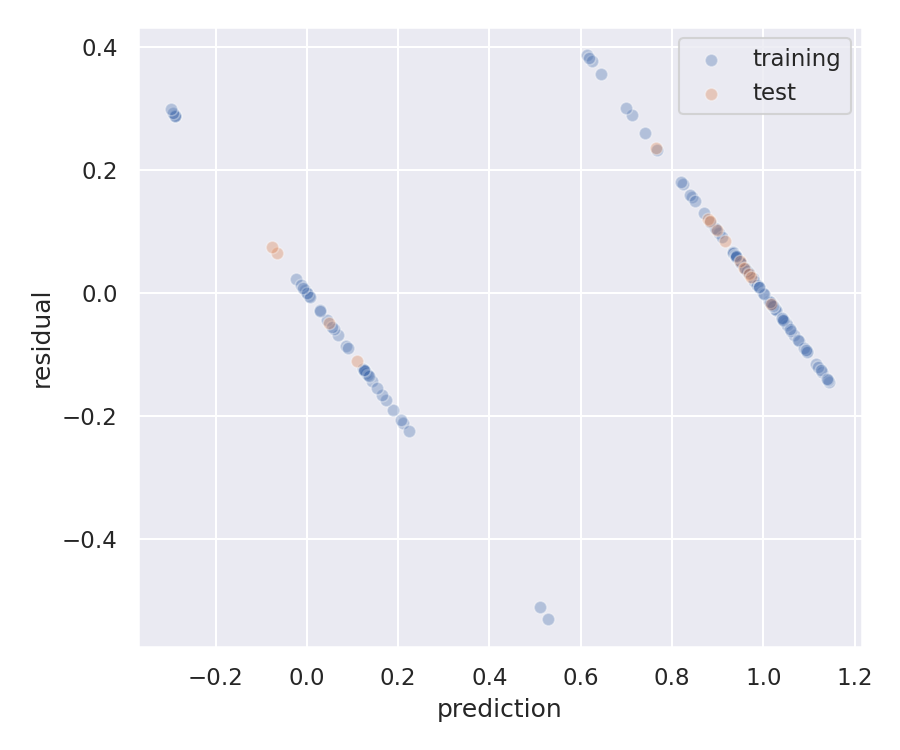

In [24]:
Image(pimg('lumps_lr_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

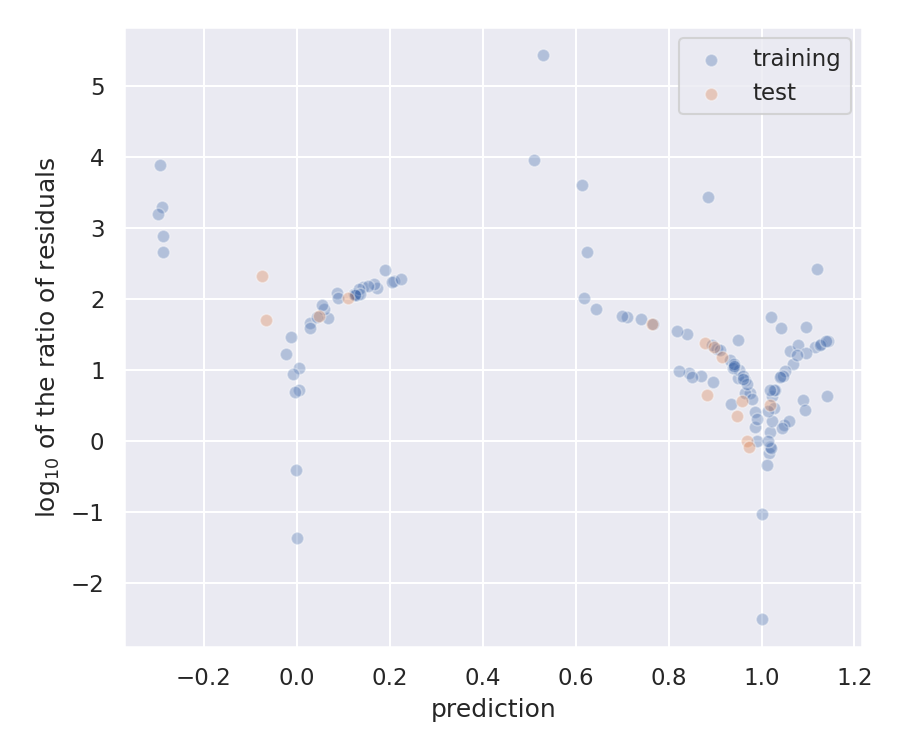

In [25]:
Image(pimg('lumps_lr_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Support Vector Machine (w/ Gaussian kernel)

In [26]:
spaces    = {'gamma':   Real(1.0e-4, 1.0e1, prior='log-uniform'),
             'C':       Real(1.0e-5, 1.0e1, prior='log-uniform'),
             'epsilon': Real(1.0e-4, 1.0e-1, prior='log-uniform')
            }
estimator = BayesSearchCV(SVR(kernel='rbf', tol=1.0e-5),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 118.119 seconds.


In [27]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.052 ± 0.003


In [28]:
# save best estimator
joblib.dump(best_estimator, pmod('lumps_svr' + SUFFIX + '.pkl'))

['./models/lumps_svr.pkl']

In [29]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet('lumps_svr_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,svr
C,4.083784
epsilon,0.000100
gamma,0.240589


In [30]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, suffix=SUFFIX, name='train_svr')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, suffix=SUFFIX, name='test_svr')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet('lumps_svr_metrics' + SUFFIX + '.csv'))
metrics

,train_svr,test_svr
mean_squared_error,0.000131,0.000630
mean_absolute_error,0.002017,0.017585
r2_score,0.999417,0.996911
residual_ratio,-1.118838,0.163388


In [31]:
make_plots(estimator, X_train, y_train, last_train, suffix=SUFFIX, name='train_svr')
make_plots(estimator, X_test, y_test, last_test, suffix=SUFFIX, name='test_svr')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], suffix=SUFFIX, name='svr')

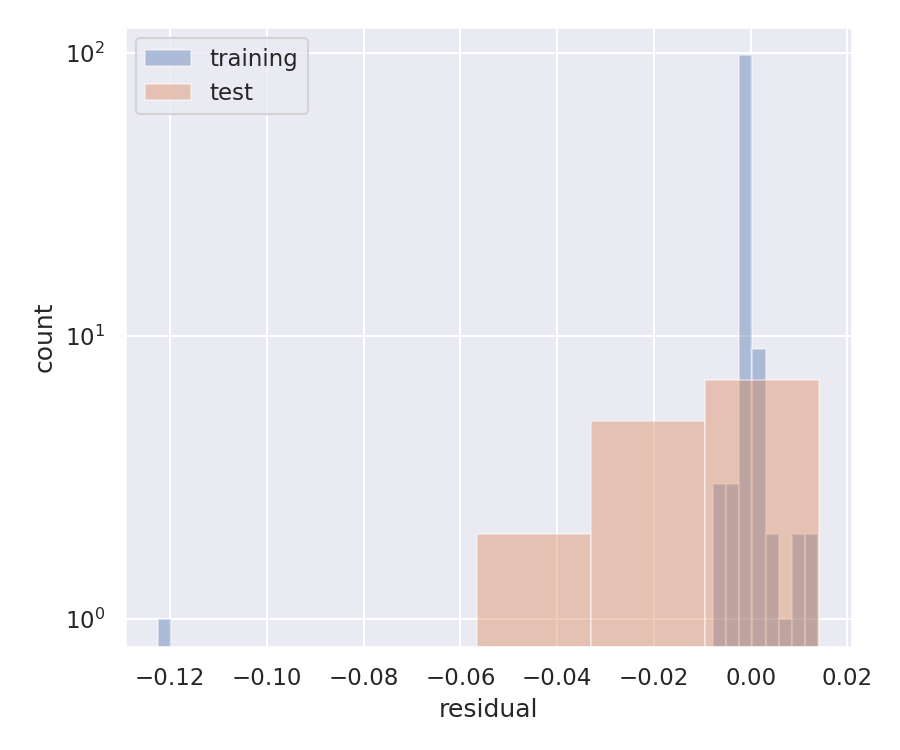

In [32]:
Image(pimg('lumps_svr_residual_histogram_compare' + SUFFIX + '.png'), width=480)

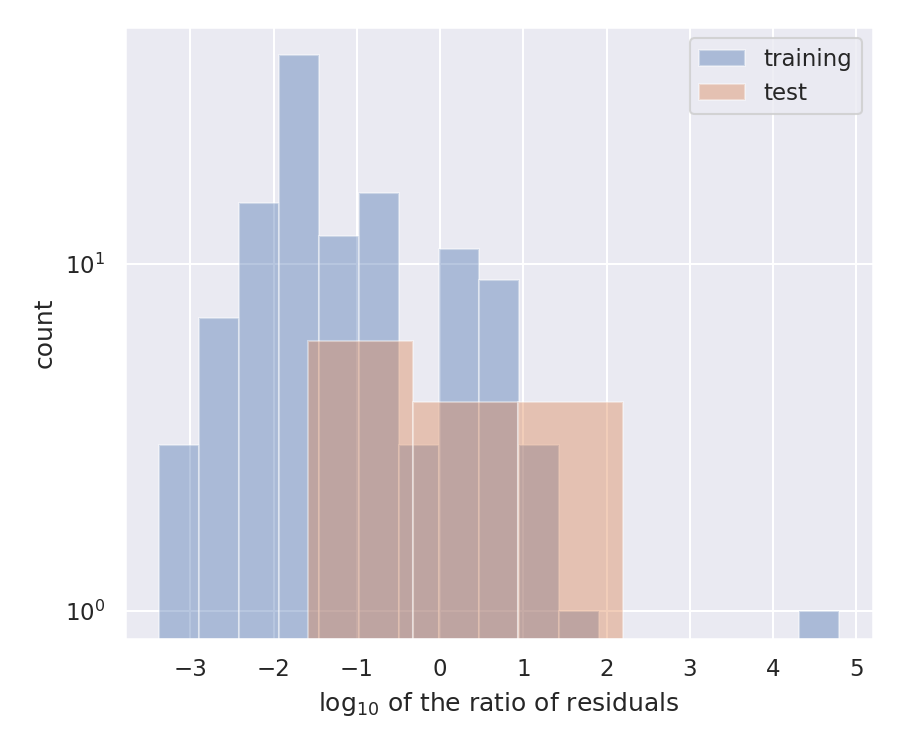

In [33]:
Image(pimg('lumps_svr_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

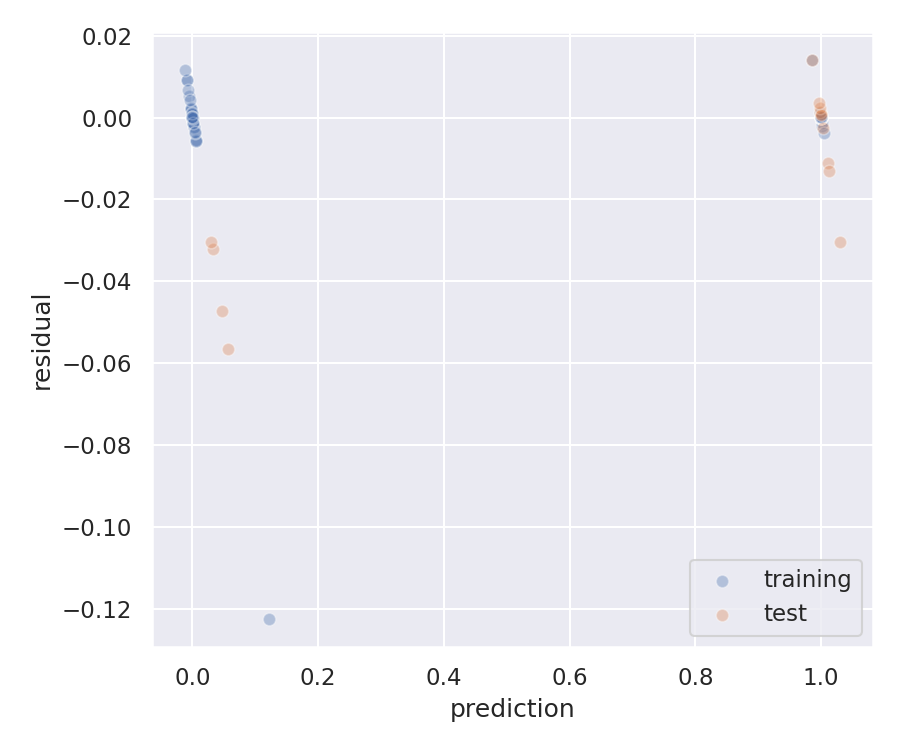

In [34]:
Image(pimg('lumps_svr_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

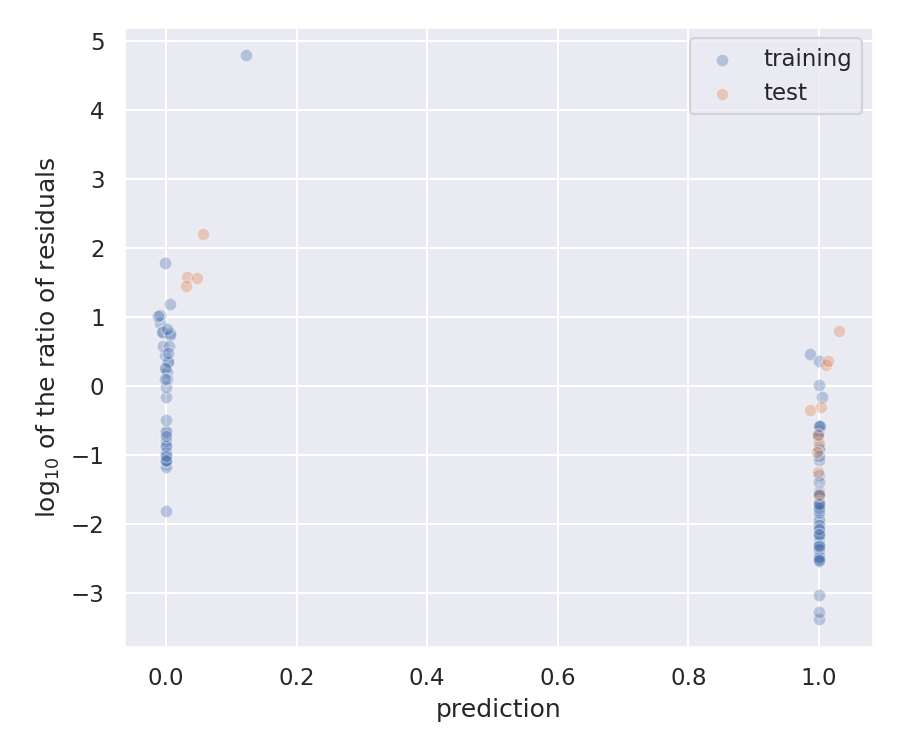

In [35]:
Image(pimg('lumps_svr_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Gradient Boosted Decision Trees

In [36]:
spaces    = {'num_leaves':       Integer(2, 100),
             'max_depth':        Integer(2, 25),
             'learning_rate':    Real(1e-5, 1e-1, prior='log-uniform'),
             'n_estimators':     Integer(1e1, 1e4, prior='log-uniform'),
             'subsample':        Real(0.8, 0.9),
             'colsample_bytree': Real(0.7, 1.0),
             'min_child_weight': Real(1.0e-3, 1.0e-1, prior='log-uniform'),
             'reg_alpha':        Real(1.0e-5, 1.0e-1, prior='log-uniform'),
             'reg_lambda':       Real(1.0e-5, 1.0e-1, prior='log-uniform')
            }
estimator = BayesSearchCV(LGBMRegressor(boosting_type='gbdt',
                                        objective='regression',
                                        subsample_freq=1,
                                        n_jobs=-1,
                                        importance_type='gain'
                                       ),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 234.164 seconds.


In [37]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.036 ± 0.002


In [38]:
# save best estimator
joblib.dump(best_estimator, pmod('lumps_gbdt' + SUFFIX + '.pkl'))

['./models/lumps_gbdt.pkl']

In [39]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet('lumps_gbdt_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,lgbmregressor
colsample_bytree,0.700000
learning_rate,0.013118
max_depth,25.000000
min_child_weight,0.001000
n_estimators,5831.000000
num_leaves,100.000000
reg_alpha,0.000010
reg_lambda,0.000010
subsample,0.800000


In [40]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, suffix=SUFFIX, name='train_gbdt')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, suffix=SUFFIX, name='test_gbdt')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet('lumps_gbdt_metrics' + SUFFIX + '.csv'))
metrics

,train_gbdt,test_gbdt
mean_squared_error,0.010217,0.004571
mean_absolute_error,0.029370,0.042368
r2_score,0.954392,0.977605
residual_ratio,0.310229,0.452794


In [41]:
make_plots(estimator, X_train, y_train, last_train, suffix=SUFFIX, name='train_gbdt')
make_plots(estimator, X_test, y_test, last_test, suffix=SUFFIX, name='test_gbdt')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], suffix=SUFFIX, name='gbdt')

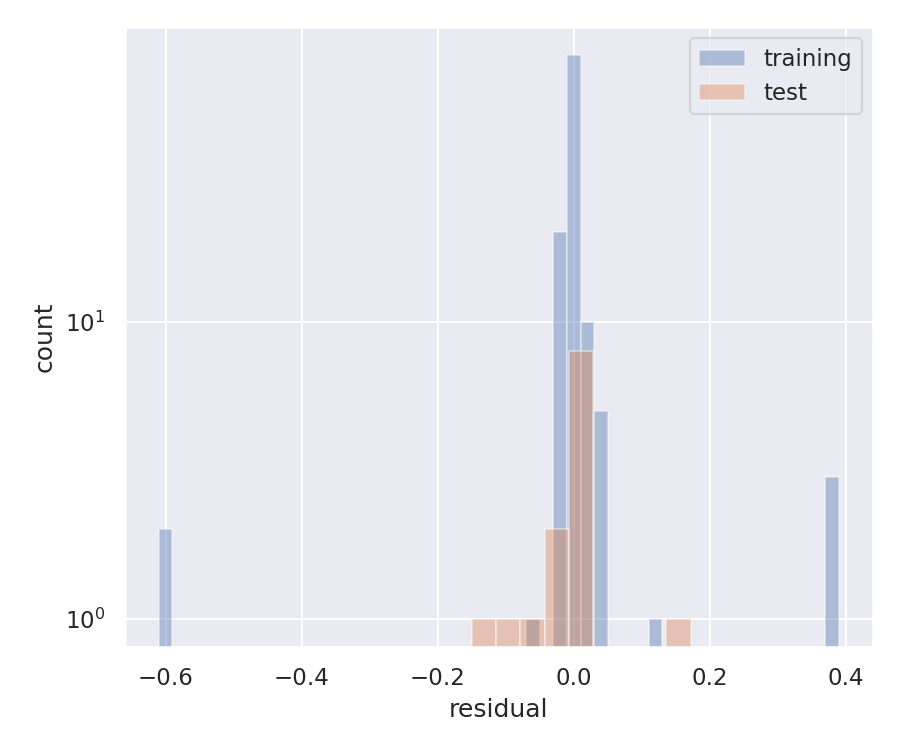

In [42]:
Image(pimg('lumps_gbdt_residual_histogram_compare' + SUFFIX + '.png'), width=480)

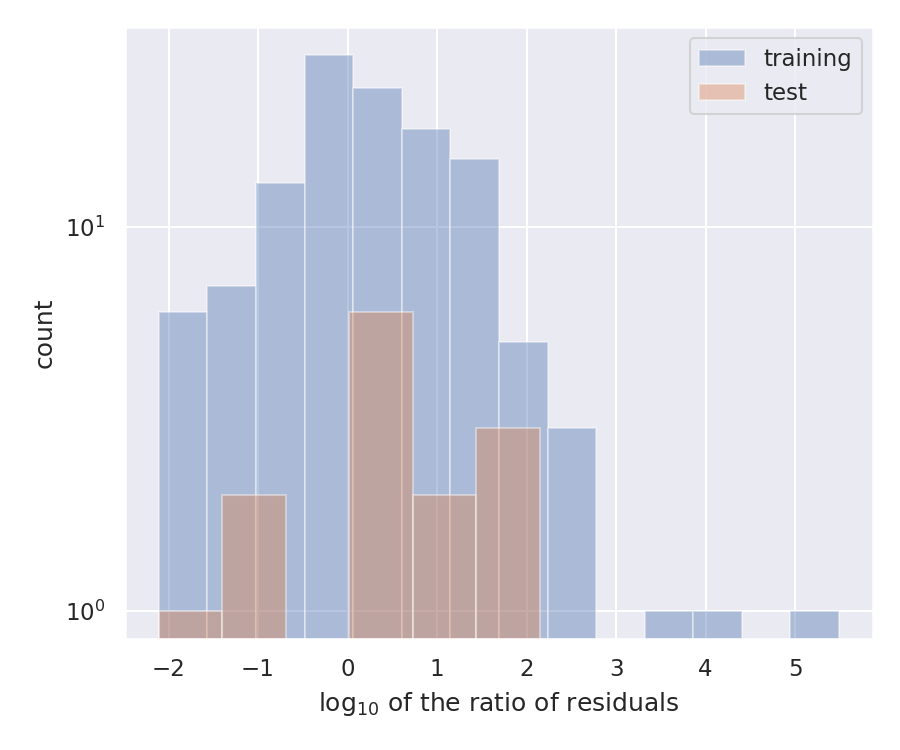

In [43]:
Image(pimg('lumps_gbdt_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

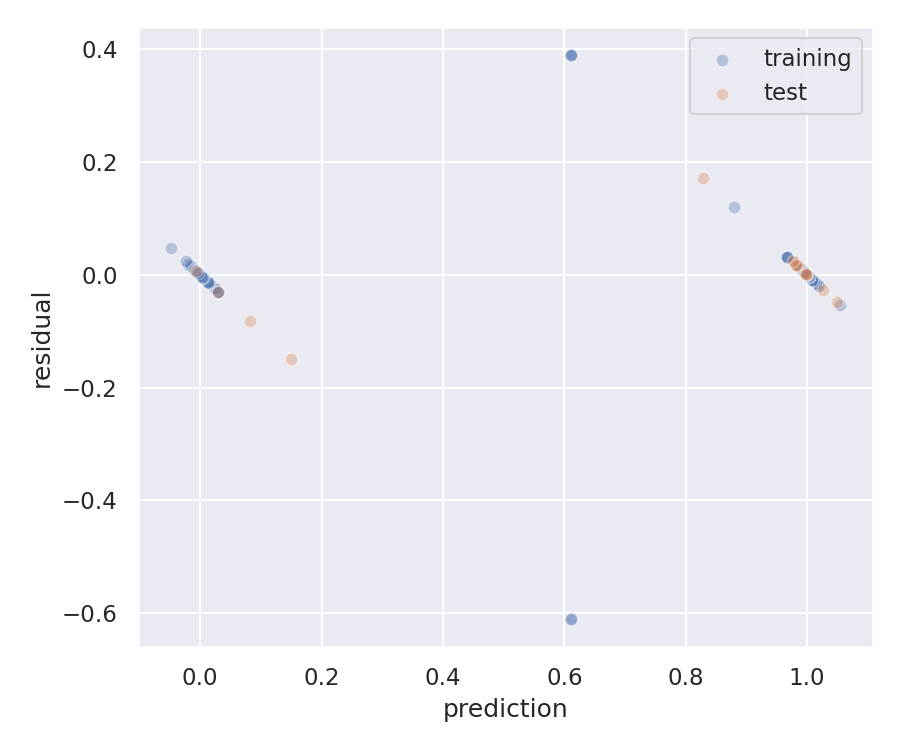

In [44]:
Image(pimg('lumps_gbdt_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

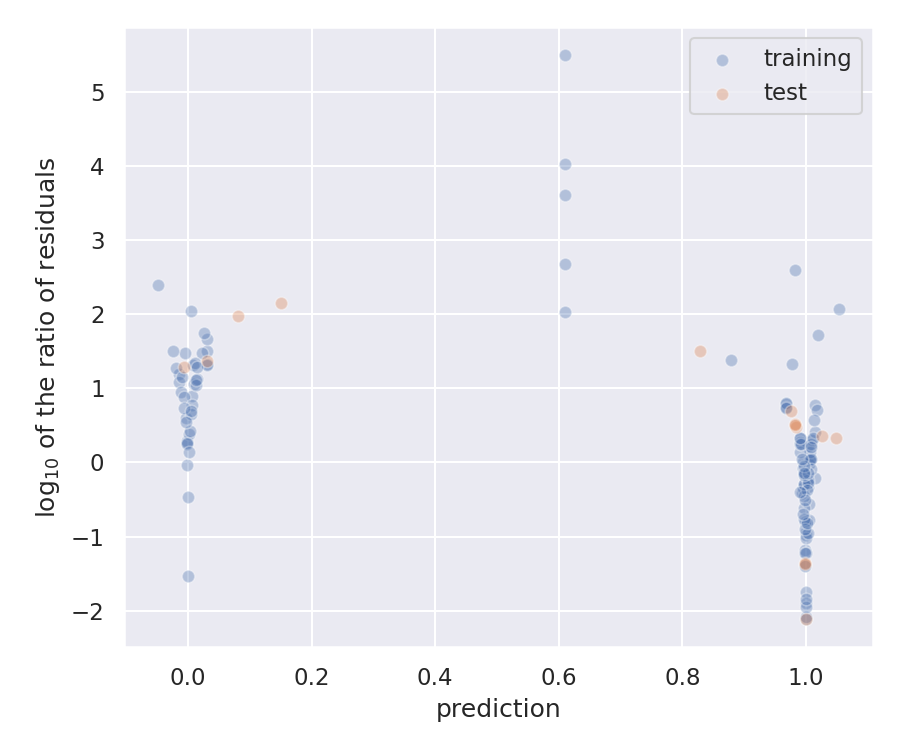

In [45]:
Image(pimg('lumps_gbdt_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Artificial Neural Network (w/ Keras)

In [46]:
keras.backend.clear_session()

ann = keras.models.Sequential([keras.layers.Input(shape=X_train_nn.shape[1:], name='input'),
                               #####################################################################
                               keras.layers.Dense(50,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.03),
                               #####################################################################
                               keras.layers.Dense(30,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(20,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(20,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(10,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               #####################################################################
                               keras.layers.Dense(10,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               #####################################################################
                               keras.layers.Dense(1, name='exp')
                              ],
                              name='lumps'
                             )
ann.compile(optimizer=keras.optimizers.Adam(learning_rate=1.0e-3),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()]
           )
ann.summary()

Model: "lumps"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620   

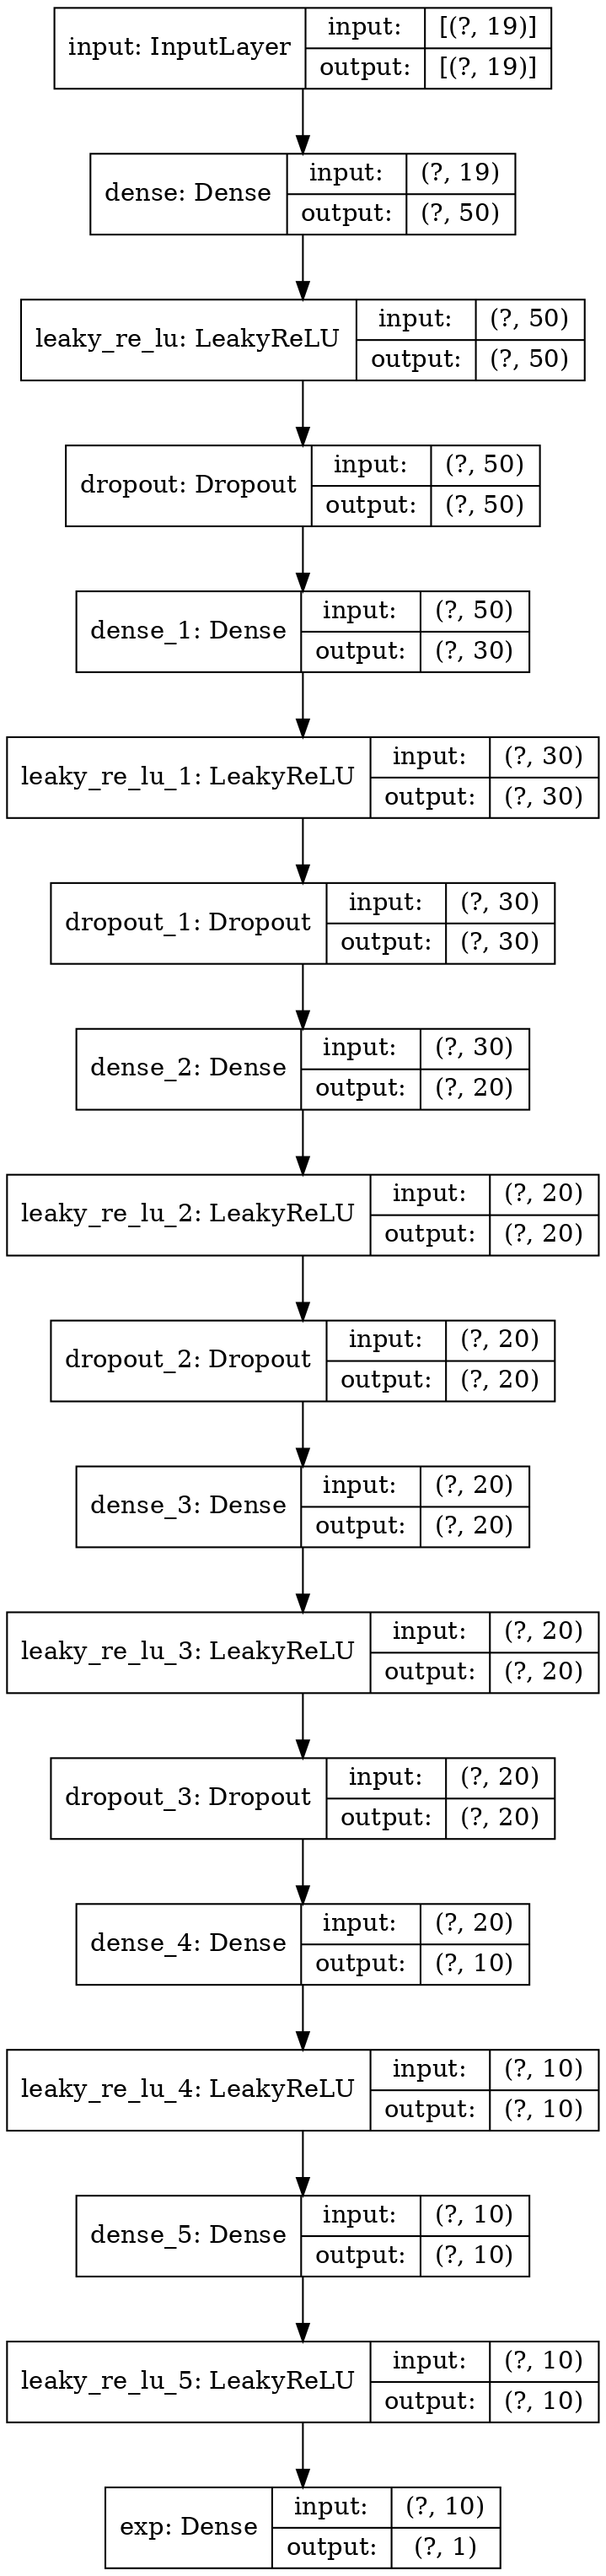

In [47]:
# save figure
ann_dot = keras.utils.model_to_dot(ann,
                                   #rankdir='LR',
                                   rankdir='TB',
                                   show_shapes=True,
                                   dpi=150)
ann_dot.write_pdf(pimg('ann_arch' + SUFFIX + '.pdf'))
Image(ann_dot.create_png(), width=320)

In [48]:
def lr_scheduler(epoch, lr):
    '''
    Schedule the learning rate:
    
    Arguments:
        epoch: the current epoch,
        lr:    the current learning rate.
    '''
    if epoch < 1000:
        return lr
    else:
        if lr <= 1.0e-6:
            return lr
        else:
            return lr * tf.math.exp(-1.0e-2)

In [49]:
t = time.time()
ann_history = ann.fit(x=X_train_nn,
                      y=y_train_nn,
                      batch_size=32,
                      epochs=10000,
                      verbose=0,
                      callbacks=[keras.callbacks.EarlyStopping(patience=1500, restore_best_weights=True, verbose=0),
                                 keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0),
                                 keras.callbacks.ModelCheckpoint(pmod('lumps_ann' + SUFFIX + '.h5'), verbose=0, save_best_only=True)
                                ],
                      validation_data=(X_val_nn, y_val_nn)
                     )
t = time.time() - t
print(f'Training took {t:.3f} seconds.')

Training took 64.479 seconds.


In [50]:
# save and display history
ann_history_obj = pd.DataFrame(ann_history.history)
ann_history_obj.to_csv(pmod('lumps_ann_history' + SUFFIX + '.csv'), index=False)
print(f'No. of epochs: {ann_history_obj.shape[0]:d}')

No. of epochs: 2605


In [51]:
history_plots(ann_history_obj, suffix=SUFFIX)

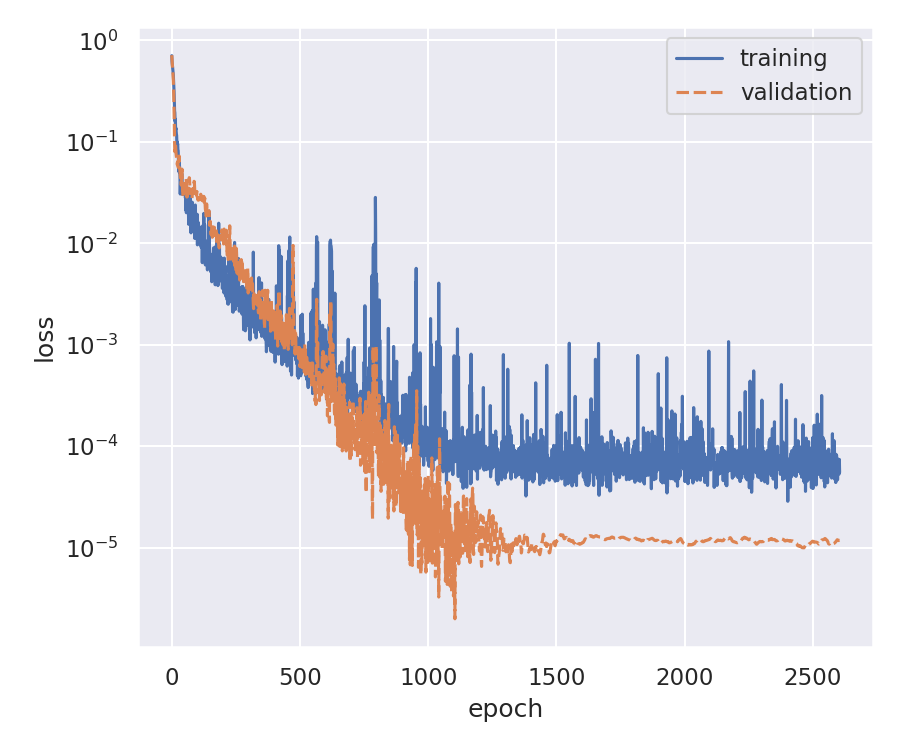

In [52]:
Image(pimg('lumps_ann_loss' + SUFFIX + '.png'), width=480)

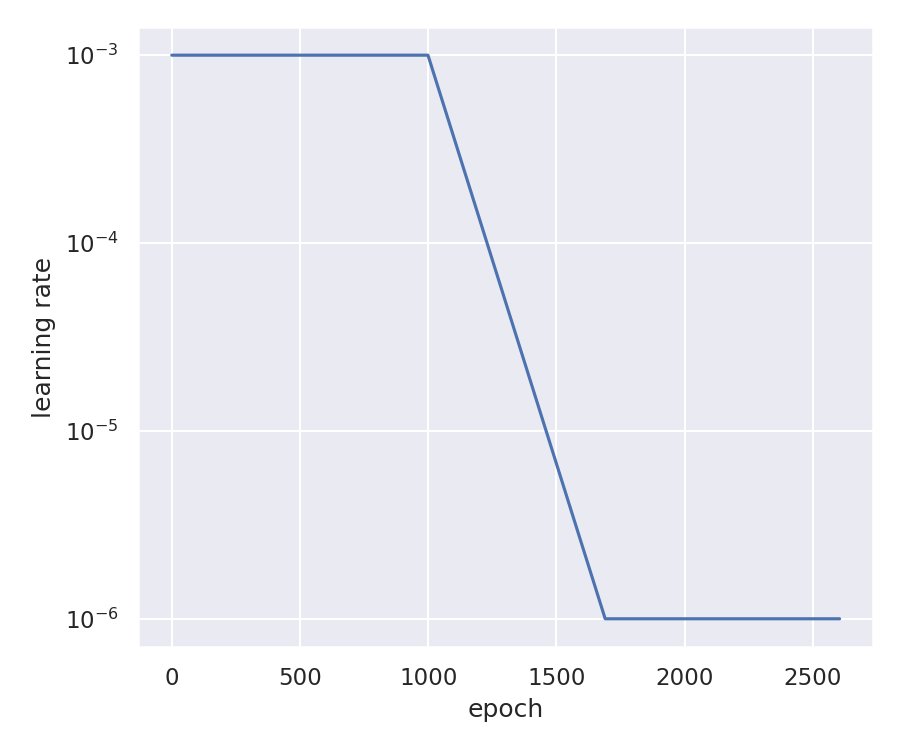

In [53]:
Image(pimg('lumps_ann_lr' + SUFFIX + '.png'), width=480)

In [54]:
train_metrics = make_predictions(ann, X_train_nn, y_train_nn, last_train_nn, suffix=SUFFIX, name='train_ann', tensor=True)
val_metrics   = make_predictions(ann, X_val_nn, y_val_nn, last_val_nn, suffix=SUFFIX, name='val_ann', tensor=True)
test_metrics  = make_predictions(ann, X_test_nn, y_test_nn, last_test_nn, suffix=SUFFIX, name='test_ann', tensor=True)

# concatenate the prediction results
metrics = pd.concat([train_metrics, val_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet('lumps_ann_metrics' + SUFFIX + '.csv'))
metrics

,train_ann,val_ann,test_ann
mean_squared_error,0.000007,0.000002,0.000002
mean_absolute_error,0.001792,0.001177,0.001237
r2_score,0.999969,0.999990,0.999989
residual_ratio,-0.395555,-0.843935,-0.763088


In [55]:
make_plots(ann, X_train_nn, y_train_nn, last_train_nn, suffix=SUFFIX, name='train_ann')
make_plots(ann, X_val_nn, y_val_nn, last_val_nn, suffix=SUFFIX, name='val_ann')
make_plots(ann, X_test_nn, y_test_nn, last_test_nn, suffix=SUFFIX, name='test_ann')
compare_plots_val(ann,
                  X_train_nn, y_train_nn, last_train_nn,
                  X_val_nn, y_val_nn, last_val_nn,
                  X_test_nn, y_test_nn, last_test_nn,
                  legend=['training', 'validation', 'test'],
                  suffix=SUFFIX,
                  name='ann'
                 )

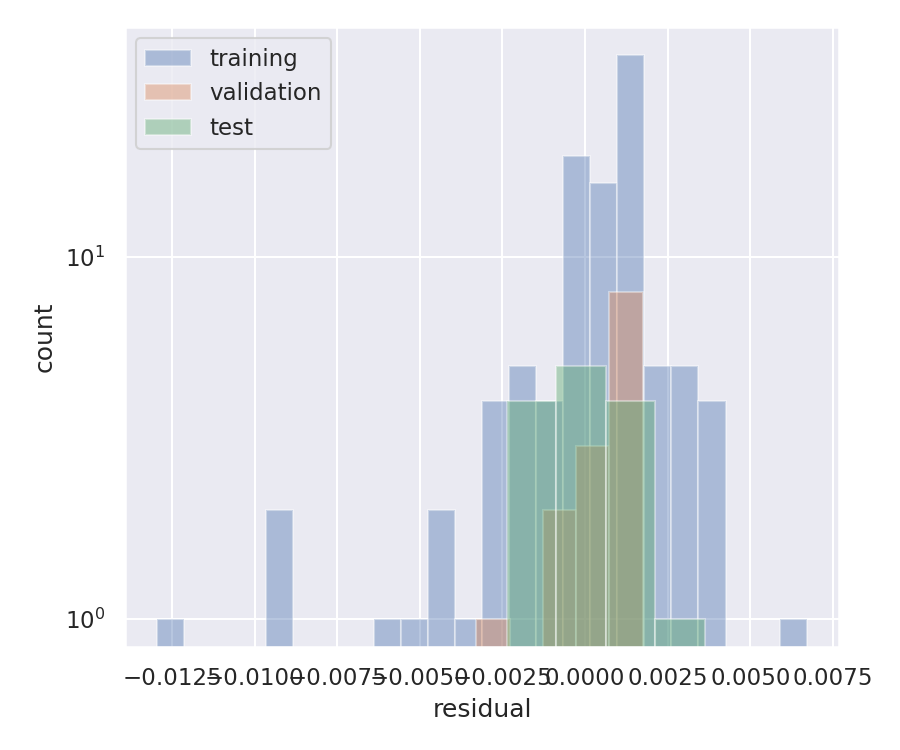

In [56]:
Image(pimg('lumps_ann_residual_histogram_compare' + SUFFIX + '.png'), width=480)

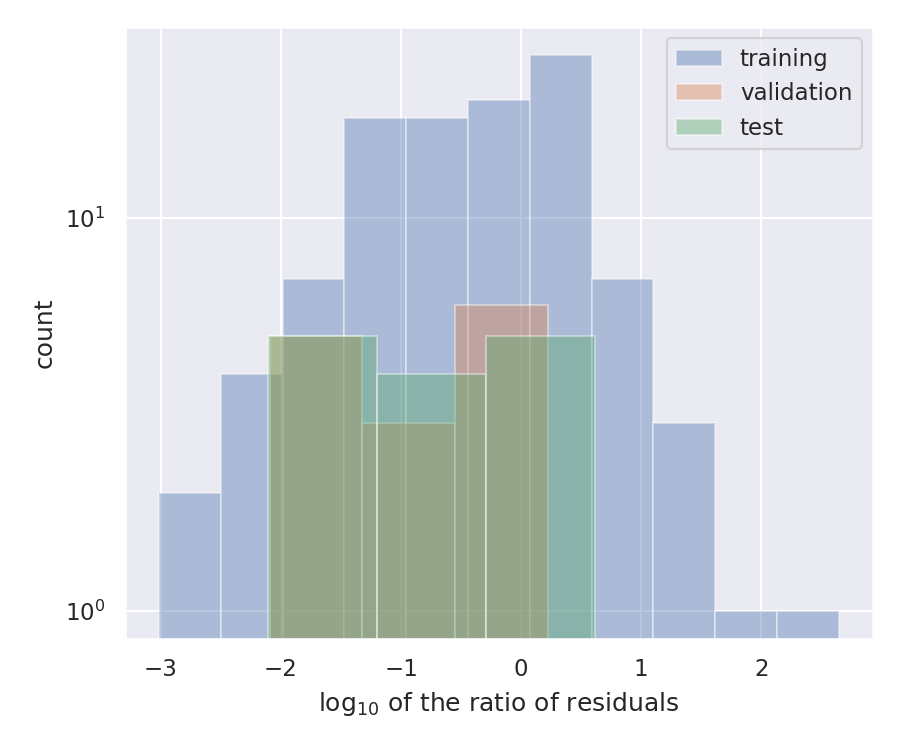

In [57]:
Image(pimg('lumps_ann_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

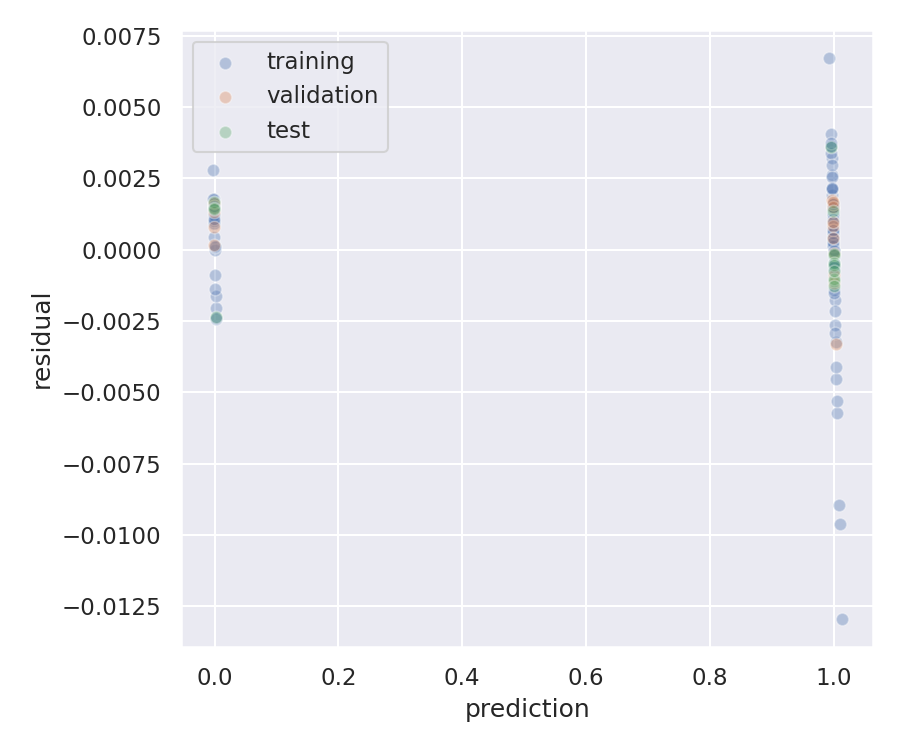

In [58]:
Image(pimg('lumps_ann_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

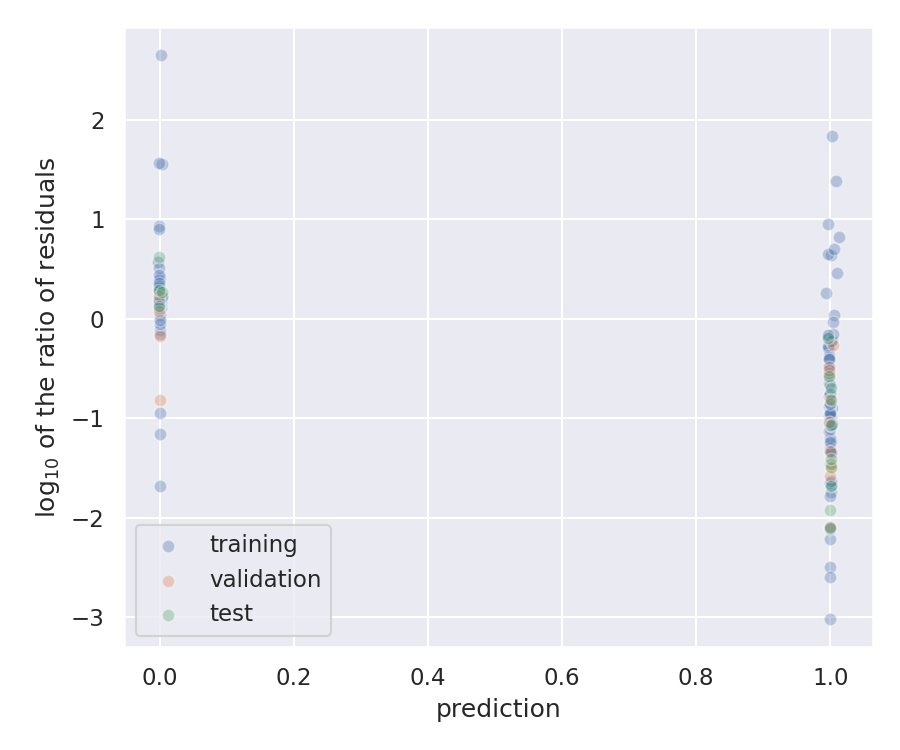

In [59]:
Image(pimg('lumps_ann_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

## Double Lumps

We finally show how the various algorithms can generalise to double lump solutions.
We keep only weight $h \le 1.25$.

In [60]:
dlumps = pd.read_csv(pdata('dlumps.csv'))
dlumps = dlumps.loc[dlumps['weight'] == 0.0]
dlumps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 5
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight    3 non-null      float64
 1   type_2    3 non-null      int64  
 2   type_4    3 non-null      int64  
 3   level_2   3 non-null      float64
 4   level_3   3 non-null      float64
 5   level_4   3 non-null      float64
 6   level_5   3 non-null      float64
 7   level_6   3 non-null      float64
 8   level_7   3 non-null      float64
 9   level_8   3 non-null      float64
 10  level_9   3 non-null      float64
 11  level_10  3 non-null      float64
 12  level_11  3 non-null      float64
 13  level_12  3 non-null      float64
 14  level_13  3 non-null      float64
 15  level_14  3 non-null      float64
 16  level_15  3 non-null      float64
 17  level_16  3 non-null      float64
 18  level_17  3 non-null      float64
 19  level_18  3 non-null      float64
 20  exp       3 non-null      float64
dt

# Extract the Labels

In [61]:
# extract the labels
y_dlumps    = dlumps['exp'].values.reshape(-1,)
y_dlumps_nn = dlumps['exp'].values.reshape(-1,)

## Apply Fourier Transform to the Levels

In [62]:
# extract the features
X_dlumps = dlumps.drop(columns=['exp']).values

# compute Fourier transform (for real input)
levels = np.fft.rfft(X_dlumps[:,3:], axis=1)

# separate modulus and argument
levels_mod = np.abs(levels)
levels_ang = np.angle(levels) / np.pi

# concatenate the arrays (the first imaginary part is identically vanishing)
levels_conc = np.c_[levels_mod[:,1:], levels_ang[:,1:]]

# join the output
X_dlumps = np.c_[X_dlumps[:,:3], levels_conc]

## Rescale the Features

In [63]:
lev_scaler    = joblib.load(pmod('lumps_levels_cv_scaler' + SUFFIX + '.pkl'))
lev_scaler_nn = joblib.load(pmod('lumps_levels_cv_scaler' + SUFFIX + '.pkl'))

# rescale the levels
X_dlumps_nn       = X_dlumps
X_dlumps[:,3:]    = lev_scaler.transform(X_dlumps[:,3:])
X_dlumps_nn[:,3:] = lev_scaler_nn.transform(X_dlumps_nn[:,3:])

## Compute Predictions

In [64]:
predictions = {'real_values': dlumps['exp'].values.reshape(-1,),
               'finite_values': dlumps['level_18'].values.reshape(-1,)
              }

# linear regression
linear = joblib.load(pmod('lumps_lr' + SUFFIX + '.pkl'))
predictions['linear_regression'] = 2 * linear.predict(X_dlumps).reshape(-1,1).reshape(-1,)

# SVR
svr = joblib.load(pmod('lumps_svr' + SUFFIX + '.pkl'))
predictions['svr'] = 2 * svr.predict(X_dlumps).reshape(-1,1).reshape(-1,)

# GBDT
gbdt = joblib.load(pmod('lumps_gbdt' + SUFFIX + '.pkl'))
predictions['gbdt'] = 2 * gbdt.predict(X_dlumps).reshape(-1,1).reshape(-1,)

# ANN
ann = keras.models.load_model(pmod('lumps_ann' + SUFFIX + '' + SUFFIX + '.h5'))
predictions['neural_network'] = 2 * ann.predict(X_dlumps_nn).reshape(-1,1).reshape(-1,)

# get dataframe
predictions = pd.DataFrame(predictions)
predictions.to_csv(pdata('lumps_dlumps_predictions' + SUFFIX + '.csv'), index=False)
predictions

,real_values,finite_values,linear_regression,svr,gbdt,neural_network
0,2.000132,2.010872,81.896498,1.651408,1.946862,8.523123
1,-0.000045,0.000039,3.557579,1.651408,0.060055,-0.707976
2,1.998589,2.008174,-26.276364,1.651408,2.180372,7.920204


In [65]:
algorithms = ['linear_regression', 'svr', 'gbdt', 'neural_network']

metrics = {'mean_squared_error': [mean_squared_error(predictions['real_values'],
                                                     predictions[f]
                                                    ) for f in algorithms
                                 ],
           'mean_absolute_error': [mean_absolute_error(predictions['real_values'],
                                                       predictions[f]
                                                      ) for f in algorithms
                                  ],
           'r2_score': [r2_score(predictions['real_values'],
                                 predictions[f]
                                ) for f in algorithms
                       ],
           'residual_ratio': [metric(predictions['real_values'],
                                     dlumps['level_18'].values.reshape(-1,),
                                     predictions[f]
                                    ) for f in algorithms
                             ]
          }

# get dataframe
metrics = pd.DataFrame(metrics, index=algorithms)
metrics.to_csv(pmet('lumps_dlumps_metrics' + SUFFIX + '.csv'))
metrics

,mean_squared_error,mean_absolute_error,r2_score,residual_ratio
linear_regression,2398.519644,37.242981,-2698.939824,3.991467
svr,0.989813,0.782452,-0.114202,2.456739
gbdt,0.013165,0.098384,0.985181,1.611406
neural_network,26.038703,4.384179,-28.310967,3.168730


In [66]:
# compute residual and residual ratio per value
residuals = {f + '_res': predictions['real_values'].values.reshape(-1,) - predictions[f].values.reshape(-1,) for f in algorithms}
ratios    = {f + '_ratio': np.log10(
                                np.abs(
                                np.divide(predictions['real_values'].values.reshape(-1,) - predictions[f].values.reshape(-1,),
                                          predictions['real_values'].values.reshape(-1,) - predictions['finite_values'].values.reshape(-1,)
                                         )
                                )
                            ) for  f in algorithms
            }

# get dataframe
residuals = pd.DataFrame(residuals)
ratios    = pd.DataFrame(ratios)
metric_per_value = pd.concat([residuals, ratios], axis=1)
metric_per_value.to_csv(pmet('lumps_dlumps_metric_per_value' + SUFFIX + '.csv'), index=False)
metric_per_value

,linear_regression_res,svr_res,gbdt_res,neural_network_res,linear_regression_ratio,svr_ratio,gbdt_ratio,neural_network_ratio
0,-79.896366,0.348724,0.053270,-6.522991,3.871526,1.511481,0.695479,2.783446
1,-3.557623,-1.651452,-0.060100,0.707931,4.627783,4.294489,2.855494,3.926614
2,28.274953,0.347181,-0.181784,-5.921615,3.469795,1.558949,1.277948,2.790833
